In [1]:
import requests
from bs4 import BeautifulSoup
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Prefectures

In [2]:
prefecture_list = [('Kyoto', 'JP-26'), ('Saga', 'JP-41'), ('Kumamoto', 'JP-43'), ('Kagawa', 'JP-37'), ('Aichi', 'JP-23'), ('Tochigi', 'JP-09'), ('Yamanashi', 'JP-19'), ('Shiga', 'JP-25'), ('Gunma', 'JP-10'), ('Miyagi', 'JP-04'), ('Shizuoka', 'JP-22'), ('Ibaraki', 'JP-08'), ('Okinawa', 'JP-47'), ('Yamagata', 'JP-06'), ('Wakayama', 'JP-30'), ('Nagasaki', 'JP-42'), ('Akita', 'JP-05'), ('Okayama', 'JP-33'), ('Fukuoka', 'JP-40'), ('Gifu', 'JP-21'), ('Aomori', 'JP-02'), ('Osaka', 'JP-27'), ('Nagano', 'JP-20'), ('Oita', 'JP-44'), ('Mie', 'JP-24'), ('Hiroshima', 'JP-34'), ('Hokkaido', 'JP-01'), ('Hyogo', 'JP-28'), ('Chiba', 'JP-12'), ('Toyama', 'JP-16'), ('Tokyo', 'JP-13'), ('Saitama', 'JP-11'), ('Yamaguchi', 'JP-35'), ('Fukushima', 'JP-07'), ('Ishikawa', 'JP-17'), ('Fukui', 'JP-18'), ('Ehime', 'JP-38'), ('Nara', 'JP-29'), ('Shimane', 'JP-32'), ('Iwate', 'JP-03'), ('Tottori', 'JP-31'), ('Tokushima', 'JP-36'), ('Kagoshima', 'JP-46'), ('Niigata', 'JP-15'), ('Kochi', 'JP-39'), ('Miyazaki', 'JP-45'), ('Kanagawa', 'JP-14')]

In [ ]:
prefecture_list_test = [('Ehime', 'JP-38')]

In [3]:
def loop_listings(listings_prop, prefecture):
  result_list = []
  for listing in listings_prop:
    #Location
    location = listing.find('span', attrs={"itemprop": "address"}).text.split()
    location_mod = location[1] + " " + location[2]

    #Rent price
    right_col = listing.find('div', class_='listing-right-col')
    right_col_items = right_col.find_all('div', class_='listing-item')
    rent = right_col_items[1].text.strip().split()[2]
    rent_price = int(rent.replace("¥","").replace(",",".").replace(".",""))

    #Apartment type
    apartment_type = right_col.find_all('span', class_='text-semi-strong')[0].text.strip()

    #Apartment size
    listing_info = listing.find('div', class_='listing-info')
    size = listing_info.find_all('div', class_='listing-item')[0].text.strip().split()[1]

    #Deposit cost
    deposit = listing_info.find_all('div', class_='listing-item')[1].text.strip().split()[1]
    deposit_cost = int(deposit.replace("¥", "").replace(",",".").replace(".",""))

    #Floor
    floor = listing_info.find_all('div', class_='listing-item')[3].text.strip().split()

    #Year built
    year_built = listing_info.find_all('div', class_='listing-item')[4].text.strip().split()[2]

    year_built_mod = None
    floor_mod = None

    if (floor[0] == "Floor"):
      floor_con = "".join([floor[1],floor[2],floor[3]])
      floor_mod = floor_con
    else:
      pass

    try:
      if (int(year_built) > 1900):
          year_built_mod = year_built
    except:
      if (floor[0] == "Year" and floor[1] == "Built"):
        year_built_mod = floor[2]
      else:
        pass
    result_list.append({"rent_price":rent_price, "deposit_cost":deposit_cost, "year_built": year_built_mod, "floor": floor_mod, "size": size,"type": apartment_type, "location": location_mod, "prefecture": prefecture})
  return result_list

In [4]:
apartments_list = []
prefecture_list_updated = []
# Limit number of pages per prefecture (page == 15 apartment listings)
pages = 2
# Swap prefecture_list with prefecture_list_test to get only chosen prefectures, all available prefectures with codes are in prefecture_list list.
for pref in prefecture_list:
  for l in range(1, 2):
    url = f"https://apartments.gaijinpot.com/en/rent/listing?page={l}&prefecture={pref[1]}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
      pag = soup.find('div', id='top').find_all('div', class_="row")[0].find_all('div')[1].find_all("li")[13].text
    except:
      pag = soup.find('div', id='top').find_all('div', class_="row")[0].find_all('div')[1].find_all("li")[10].text

    if len(pag.split()) < 5:
      continue
    if int(pag.split()[4]) < 16:
      aparts_count = 1
    else:
        aparts_count = math.floor(int(pag.split()[4]) / 15)
        if aparts_count > pages:
          aparts_count = pages
    prefecture_list_updated.append((pref[0],pref[1], aparts_count))

for pref in prefecture_list_updated:
  for l in range(1, pref[2]+1): #1/5
    url = f"https://apartments.gaijinpot.com/en/rent/listing?page={l}&prefecture={pref[1]}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    listings = soup.find_all('div', class_='property-listing')
    ap_list = loop_listings(listings, pref[0])
    apartments_list += ap_list

In [30]:
# Coverting to dataframe, dropping missing values
df = pd.DataFrame(apartments_list)
df_filtered = df.dropna()
print(f"Dataframe length before dropping null values:{len(df)}")
print(f"Dataframe length after dropping null values:{len(df_filtered)}")


Dataframe length before dropping null values:1289
Dataframe length after dropping null values:1158


#Identifying outliers




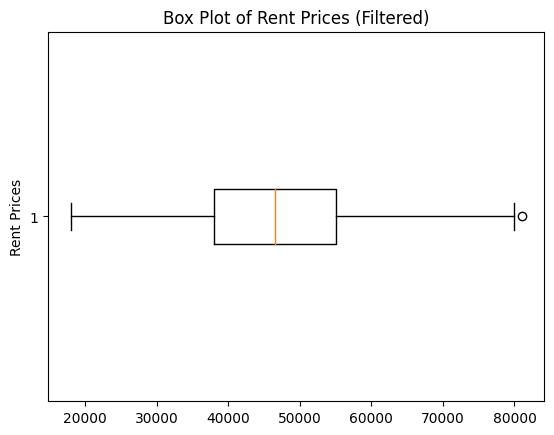

In [7]:
rent_prices = df_filtered['rent_price']

# Calculating the IQR
Q1 = rent_prices.quantile(0.25)
Q3 = rent_prices.quantile(0.75)
IQR = Q3 - Q1

# Removing outliers beyond 1.5 * IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_outliers = df_filtered[(rent_prices >= lower_bound) & (rent_prices <= upper_bound)]

# Creating a box plot of the filtered rent prices
plt.boxplot(df_outliers['rent_price'], vert=False)

df = df_outliers
# Adding labels and title
plt.ylabel('Rent Prices')
plt.title('Box Plot of Rent Prices (Filtered)')
# Displaying the plot
plt.show()

#Average rent price

46535.687331536385


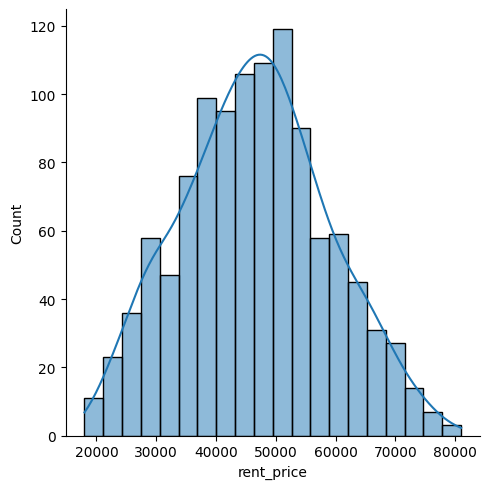

In [29]:
average_price = df['rent_price'].mean()
print(average_price)
sns.displot(data=df, x="rent_price", kde=True)

30


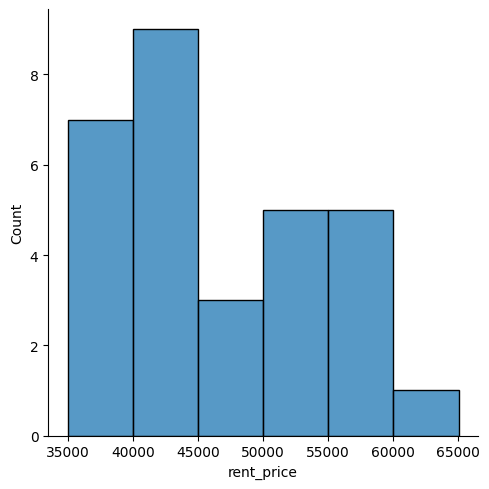

In [27]:
def prefecture_rent_price_graph(df, prefecture):
  df_prefecture = df[df['prefecture'] == prefecture]
  sns.displot(data=df_prefecture, x="rent_price")

prefecture_rent_price_graph(df, "Kumamoto")

#Rent prices differentiated by location in a chosen prefecture

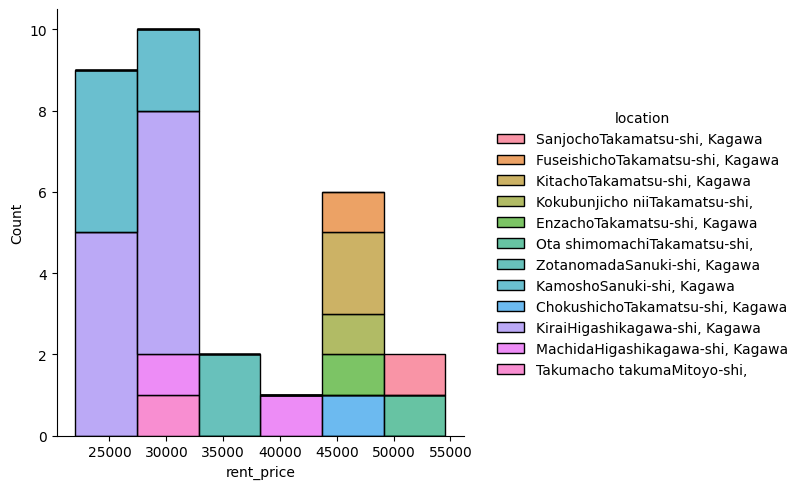

In [36]:
def prefecture_location_rent_price_graph(df, prefecture):
  df_prefecture = df[df['prefecture'] == prefecture]
  sns.displot(data=df_prefecture, x="rent_price", hue="location", multiple="stack")

prefecture_location_rent_price_graph(df, "Kagawa")

In [38]:
# Saving csv file to data folder.
df.to_csv('./data/apartments.csv', index=False)